<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/CBPE_0915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBPE 실험

+ 이번 실험에서 가장 중요 Point는 아래 2가지
> 1. uncertainty(reference, inference, model) 측정에서 reference의 사이즈와, inference의 사이즈를 동일하게 유지.
> 2. 1번과 연동하여 sliding window 형식으로 live_set을 적용.
<pre>
초기 Input dataset
 +---------------------------------------+----------------+
 |              Trainset (100개)         | Testset (10개) |
 +---------------------------------------+----------------+
 이때 초기 Metric 측정 및 uncertainty의 inference는 아래와 같이 구성됨. (해당 Set으로 Noise 유도)
       +---------------------------------+----------------+
       |       Trainset(10:100) 90개     | Testset (10개) |  100개
       +---------------------------------+----------------+
첫번째 Liveset
               +-------------------------+----------------+----------------+
               |   Trainset 80개         | Testset (10개) |  Liveset(10개) | 100개
               +-------------------------+----------------+----------------+
두번째 Liveset
                      +------------------+----------------+--------------------------------+
                      |    Trainset 70개 | Testset (10개) |          Liveset(20개)         | 100개
                      +------------------+----------------+--------------------------------+
세번째 Liveset
Trainset 60개 + Testset 10개 + Liveset 30개 = 100개
</pre>
+ 이상과 같은 조건으로 Noise를 유도하고 실험 검증하면, 완벽하지는 않으나 비교적 활용 가능한 정도의 Threshold를 산출 할 수 있다.
+ Drift의 발생을 감지 못 할 경우도 있다.
+ Sigma 값은 0~1 사이로 낮게 적용. block sampling 적용. Noise Sample의 개수 = Trainset 의 개수
<pre>
    exp_model_param = {
        "exp_num":[400],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":[accuracy, f1]
        }
</pre>

# 1 구글 드라이브 연결

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# package install

In [1]:
!pip install nannyml
!pip install sdv==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 15.9 MB/s eta 0:00:00


# 2 함수 선언



In [2]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp,exp_model_param):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(df_state,x_inf_d,exp_model_param):
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])
    #print(permutaion_sigma)
    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data(exp_model_param,x_train,train_gt ):
    temp_X = []
    temp_Y = []
    mean = np.mean(x_train,axis=0)
    std = np.std(x_train,axis=0)
    df_state = pd.DataFrame({"mean":mean,"std":std})

    print('random_sigma_add, mean:',mean)
    print('random_sigma_add, std:',std)

    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train,exp_model_param)
        temp_X.append(random_sigma_add(df_state,x_train[sample_idx],exp_model_param))
        temp_Y.append(train_gt[sample_idx])
    return np.asarray(temp_X), np.asarray(temp_Y)

In [3]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def D3(reference, inference, model):
    y1 = np.zeros(reference.shape[0]).reshape(-1, 1)
    y2 = np.ones(inference.shape[0]).reshape(-1, 1)
    X = np.vstack((reference, inference))
    y = np.vstack((y1, y2))
    lr = LogisticRegression(solver="lbfgs", random_state=0, max_iter=5000).fit(X, y.ravel())
    return roc_auc_score(y, lr.predict_proba(X)[:, 1])

from scipy.stats import ks_2samp, entropy
def uncertainty(reference, inference, model):
    entropy_ref = entropy(model.predict_proba(reference), axis = -1)
    entropy_inf = entropy(model.predict_proba(inference), axis = -1)
    d, p = ks_2samp(entropy_ref, entropy_inf)
    return d

from scipy.linalg import sqrtm
def FID(reference, inference, model):
    act_ref, act_inf = [], []

    #print('FID reference:',reference.shape)
    #print('FID inference:',inference.shape)

    for i in range(reference.shape[0]):
        refr, infr = reference[i, :], inference[i, :]
        vmin, vmax = min(refr.min(), infr.min()), max(refr.max(), infr.max())
        bins = int(1+3.322*np.log10(max(len(refr), len(infr))))
        refh, _ = np.histogram(refr, range=(vmin, vmax), bins=bins)
        infh, _ = np.histogram(infr, range=(vmin, vmax), bins=bins)
        act_ref.append(refh)
        act_inf.append(infh)

    act_ref = np.array(act_ref)
    act_inf = np.array(act_inf)
    mu1, sigma1 = np.mean(act_ref, axis=0), np.cov(act_ref, rowvar=False)
    mu2, sigma2 = np.mean(act_inf, axis=0), np.cov(act_inf, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    mat_dot = sigma1.dot(sigma2)
    covmean = sqrtm(mat_dot)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [173]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    if ks_stat == minS:
        ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

## 준비

In [5]:
# 실험 모델 환경 설정
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,r2_score
def accuracy(model, X, y):
    return accuracy_score(model.predict(X), y)*100

def f1(model, X, y):
    return f1_score(model.predict(X), y) *100


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [7]:
main_figsize = (15,3)

def MI_Drift_F1(model, X,y,train_size,test_size,bucket_size=200):

    MIS = {}
    DRF = {}
    F1S = []
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    step_size = int((X.shape[0]-(train_size+test_size))/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tmp_x = X[bk*bucket_size:bk*bucket_size+bucket_size]
        tmp_y = y[bk*bucket_size:bk*bucket_size+bucket_size]
        mi_scores = make_mi_scores(tmp_x,tmp_y , discrete_features="auto")
        ks = __ks_drift(X[0:train_size].values,
                        X[bk*bucket_size+(train_size+test_size):bk*bucket_size+bucket_size+(train_size+test_size)].values)
        #predicted_y = model.predict(tmp_x)
        f1_ = f1(model,tmp_x,tmp_y)
        F1S.append(f1_)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[columns].values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[columns].values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(F1S,linewidth=1,label='f1 score')
    plt.ylabel('F1 Score')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1)
    plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

class DriftDetector():
    def __init__(self, threshold,n=3):

        self.threshold = threshold
        self.n = n
        self.current_count = 0
        self.time = 0
        self.value = 0.0

    def detect(self, drift_value):
        if self.current_count >= self.n:
            return True

        if self.threshold < drift_value:
            self.current_count = self.current_count +1
        else:
            self.current_count = 0

        self.value = drift_value
        if self.current_count >= self.n:
            return True

        self.time = self.time + 1
        return False

def experiment(X,y,train_size,test_size,threshold=85):

    seed_everything()

    # Normalize
    scaler_c1 = StandardScaler()
    scaler_c1.fit(X[0:train_size])
    X = pd.DataFrame(scaler_c1.transform(X), columns=columns)
    # Model train...
    model = RandomForestClassifier(max_depth=6).fit(X[0:train_size], y[0:train_size])
    # Dataset 구성
    x_train = X.values[:train_size]
    y_train_gt = y[:train_size].reshape(-1,1)

    mi_scores = make_mi_scores(pd.DataFrame(x_train,columns=columns), y[:train_size], discrete_features="auto")
    max_mi = np.max(mi_scores)

    x_test = X[test_size:train_size+test_size].values
    y_test_gt = y[test_size:train_size+test_size].reshape(-1,1)

    x_live = X[test_size:].values
    y_live_gt = y[test_size:].reshape(-1,1)

    print('Structure of dataset, x_train:',x_train.shape, 'x_test:',x_test.shape, 'x_live:',x_live.shape)

    # 기타 parameter 구성
    ######################################### sigma 를 수정
    exp_model_param = {
        "exp_num":[400],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":[accuracy, f1]
        }
    '''
    if max_mi < 0.01:
        exp_model_param['sigma'] = [0,1/max_mi]
        print(exp_model_param['sigma'])
    '''

    # Testset의 Metric 측정
    test_score = []
    # 후미 test_size 개수만 대상.
    print(f'uncertainty: (x_train={x_train.shape}, x_test={x_test.shape})')
    test_unc = uncertainty(x_train,x_test,model)
    metric_name = []
    for i, metric in enumerate(exp_model_param['metric']):
        metric_name.append(metric.__name__)
        test_score.append(metric(model,x_test,y_test_gt))

    print(f'Max MI for Trainset {max_mi:.5f}, Testset metric {metric_name}:{test_score}, Testset uncertainty : {test_unc:.5f}')

    # Noise 주입!
    exp_X_list, exp_y_list = add_drirft_data(exp_model_param,x_test,y_test_gt)

    print('Noise set : ',exp_X_list.shape)
    result_d_value = []
    result_score = []
    for exp_X,exp_y in zip(tqdm(exp_X_list),exp_y_list):
        # 설정한 Metric을 기반으로 Score 계산
        exp_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            exp_score.append(metric(model,exp_X, exp_y))
        result_score.append(exp_score)
        # Uncertainty 계산
        result_d_value.append(uncertainty(x_train, exp_X,model))

    result_d_value = np.asarray(result_d_value)
    result_score = np.asarray(result_score)

    exp_lr_model = LinearRegression().fit(result_d_value.reshape(-1, 1),result_score[:,0])
    '''
    # Upper, Lower LinearRegression 학습...
    exp_df = pd.DataFrame({'DV':result_d_value,'SC':result_score[:,0]})
    exp_df = exp_df.sort_values(by=['DV'], ascending=True)

    width = 20
    exp_df_set = [exp_df[i:i+width] for i in range(0,exp_df.shape[0],width)]

    # 여기서, upper와 lower 를 나눈다.
    exp_upper = []
    exp_lower = []

    for df_set in exp_df_set:
        mx_set = df_set[df_set['SC'] == np.max(df_set['SC'])]
        mn_set = df_set[df_set['SC'] == np.min(df_set['SC'])]
        exp_upper.append([mx_set['DV'].values[0],mx_set['SC'].values[0]])
        exp_lower.append([mn_set['DV'].values[0],mn_set['SC'].values[0]])

    exp_upper = np.asarray(exp_upper)
    exp_lower = np.asarray(exp_lower)
    #print('exp_upper,',exp_upper.shape)
    #print('exp_lower,',exp_lower.shape)

    exp_up_model = LinearRegression().fit(exp_upper[:,0].reshape(-1, 1),exp_upper[:,1])
    exp_lw_model = LinearRegression().fit(exp_lower[:,0].reshape(-1, 1),exp_lower[:,1])
    #exp_in_model = LinearRegression().fit(result_score[:,0].reshape(-1, 1),result_d_value)


    ############################# 보정 처리 ############################
    # 실험 LinearRegression의 Y 절편 (drift가 없을 때의 metric) 을 testset의 metric에 맞춤
    # 실험 drift(uncen)의 최소값을 testset의 drift(uncen)에 맞춤
    delta = test_score[0] - exp_lw_model.intercept_
    print(f'Y Adjustment:{delta:.5f}')

    delta_x = np.min(result_d_value) - test_unc
    print(f'X Adjustment:{delta_x:.5f}')
    ######################################################################
    '''
    # real data의 score vs drift 취득
    live_set = []
    live_set_y = []
    truncate_count = 0
    bucket_size=(train_size,test_size)
    for i in range(int(x_live.shape[0]/bucket_size[1])):
        xl = x_live[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        yl = y_live_gt[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        if len(xl) ==  train_size:
            live_set.append(xl)
            live_set_y.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {x_live.shape}')

    live_set = np.asarray(live_set)
    live_set_y = np.asarray(live_set_y)

    real_scores = []
    real_d_value = []
    print('Live set : ',live_set.shape)
    for live_unit,live_unit_y in zip(tqdm(live_set), live_set_y):#tqdm(zip(live_set,live_set_y)):
        # 설정한 Metric을 기반으로 Score 계산
        real_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            real_score.append(metric(model,live_unit,live_unit_y))
        real_scores.append(real_score)
        # Uncertainty 계산
        real_d_value.append(uncertainty(x_train,live_unit,model))

    real_d_value = np.asarray(real_d_value)
    real_scores = np.asarray(real_scores)

    real_lr_model = LinearRegression().fit(real_d_value.reshape(-1, 1),real_scores[:,0])
    #real_in_model = LinearRegression().fit(real_scores[:,0].reshape(-1, 1),real_d_value)

    dd = np.concatenate((result_d_value,real_d_value),axis=0)

    d_min = np.min(dd)
    d_max = np.max(dd)
    xsx = np.arange(d_min-(d_max-d_min)/100,d_max,(d_max-d_min)/100)

    #plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    #plt.show()

    plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
    plt.plot(xsx,exp_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_line')
    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    exp_d_value = (threshold - exp_lr_model.intercept_) / exp_lr_model.coef_[0]
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')
    '''
    print("################ 보정 처리 ###############")

    plt.scatter(result_d_value-delta_x,result_score[:,0]+delta,marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')

    plt.plot(xsx-delta_x,exp_lr_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_line')

    plt.plot(xsx-delta_x,exp_up_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_up_line')
    plt.plot(xsx-delta_x,exp_lw_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_ - delta) / exp_lr_model.coef_[0] - delta_x
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')
    '''
    plt.figure(figsize=(15,3))
    predict_scores = exp_lr_model.predict(real_d_value.reshape(-1,1))
    plt.plot(predict_scores,linewidth=1,label='exp score')
    # 보정한 결과로 R2 측정
    plt.plot(real_scores[:,0],linewidth=2,label='real score')
    #predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))
    #plt.plot(predict_scores,linewidth=1,linestyle = ':', label='exp score')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    print(f'r2 of expected metric vs real metric :{r2_score(real_scores[:,0],predict_scores):.5f}')


    plt.figure(figsize=(15,3))
    plt.plot(real_d_value,linewidth=1,label='uncen value')
    #plt.axhline(y = test_unc, color = 'b', linestyle = ':',label='test_uncen')
    #th1 = test_unc + test_unc * 0.1
    #th2 = test_unc + test_unc * 0.2
    th3 = test_unc + test_unc * 0.3
    #plt.axhline(y = th1, linestyle = ':',label='test_uncen(10%)')
    #plt.axhline(y = th2, linestyle = ':',label='test_uncen(20%)')
    plt.axhline(y = exp_d_value, linestyle = ':',color = 'r', label='expected uncertainty')

    # test_uncen(30%)을 threshold로 설정, 3회 연속 over일 경우, detect
    ddd = DriftDetector(exp_d_value,2)
    dt = [ddd.detect(v) for v in real_d_value]
    if np.sum(dt) > 0:
        plt.axvline(x = ddd.time, color='r', linestyle = ':',label='detect')
        print(f'Detect at {ddd.time} time, uncertainty {ddd.value:.5f} metric {real_scores[ddd.time,0]:.5f}')
    else:
        print('Detect fail!!')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()



#4 실험

## Real-world data(Loan data)의 실험

### Data 준비

In [9]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [10]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [11]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [12]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df_accepted.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [13]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [14]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375188
last_fico_range_high    0.093529
last_pymnt_amnt         0.085770
total_rec_late_fee      0.032193
int_rate                0.016749
                          ...   
E4                      0.000000
F1                      0.000000
F2                      0.000000
F5                      0.000000
loan_amnt               0.000000
Name: MI Scores, Length: 81, dtype: float64


### Loan Data 실험

In [15]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

#### 실험 #1 Top 1~5, 4개의 feature 적용

In [16]:
top_columns = list(mi_scores[1:5].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

In [17]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2]

In [18]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

In [20]:
# 1/10 로 사이즈 줄이기...
seed_everything()
s = np.sort(np.random.choice(X2.shape[0],int(X2.shape[0]/10),replace= False))
#print(s.shape)
X3 = X2.iloc[s,:]
Y3 = Y2[s]

In [21]:
X3

,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate
8,754.0,5.81,0.0,8.94
19,739.0,24.70,0.0,13.92
41,769.0,845.25,0.0,12.53
43,719.0,182.76,0.0,13.92
52,809.0,284.71,0.0,8.59
...,...,...,...,...
1279596,529.0,248.30,0.0,7.35
1279609,729.0,26625.79,48.2,30.75
1279627,744.0,2216.56,0.0,10.42
1279639,579.0,628.61,0.0,13.59


#### NannyML CBPE
+ https://nannyml.readthedocs.io/en/stable/installing_nannyml.html

In [131]:
import nannyml as nml
from IPython.display import display

train_size = 2000
# train classifier

scaler = MinMaxScaler()
sx = scaler.fit_transform(X3[0:train_size].values)

model = RandomForestClassifier(max_depth=6).fit(sx, Y3[0:train_size])
reference_df = X3[0:train_size]
reference_df['loan_paid'] = Y3[0:train_size]
reference_df['y_pred'] = model.predict(X3[0:train_size])
reference_df['y_pred_proba'] = model.predict_proba(scaler.transform(X3[0:train_size].values))[:,1]

#train CBPE
estimator = nml.CBPE(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='loan_paid',
    chunk_number = 1,
    metrics=['f1'],
    problem_type='classification_binary',
)
estimator.fit(reference_df)

In [134]:
from tqdm import tqdm
from sklearn.metrics import f1_score,r2_score,precision_score

test_size = 1000

x_test = X3[test_size:train_size+test_size]
y_test = Y3[test_size:train_size+test_size].reshape(-1,1)

x_live = X3[test_size:]
y_live = Y3[test_size:].reshape(-1,1)

x_live_chunk = []
y_live_chunk = []
truncate_count = 0
for i in range(int(x_live.shape[0]/test_size)):
    xl = x_live[i*test_size:i*test_size+train_size]
    yl = y_live[i*test_size:i*test_size+train_size]
    if len(xl) ==  train_size:
        x_live_chunk.append(xl)
        y_live_chunk.append(yl)
    else:
        truncate_count = truncate_count + len(xl)

print(f'Truncate {truncate_count} rows from live_set {x_live.shape}')

real_f1s = []
cbpe_f1s = []

for x_chunk,y_chunk in zip(tqdm(x_live_chunk),y_live_chunk):
    y_pred = model.predict(scaler.transform(x_chunk))
    analysis_df = x_chunk
    analysis_df['y_pred_proba'] = model.predict_proba(scaler.transform(x_chunk))[:,1]
    analysis_df['y_pred'] =y_pred
    results = estimator.estimate(analysis_df)
    real_f1s.append(f1_score(y_chunk,y_pred))
    cbpe_f1s.append(results.filter(period='analysis').to_df()[[('f1','value')]].values[0,0])

Truncate 1968 rows from live_set (126968, 4)


100%|██████████| 125/125 [00:09<00:00, 13.78it/s]


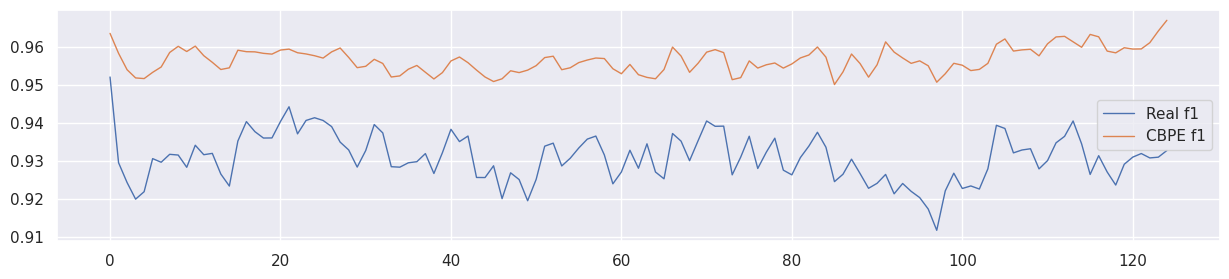

In [135]:
plt.figure(figsize=(15,3))
plt.plot(real_f1s,linewidth=1,label='Real f1')
plt.plot(cbpe_f1s,linewidth=1,label='CBPE f1')
plt.legend()
plt.show()

# PPM

In [129]:
import copy
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def train_regression_model(X,Y,n_epochs=1000):
    seed_everything()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)

    X = torch.tensor(X,dtype=torch.float32).to(device)
    Y = torch.tensor(Y,dtype=torch.float32).to(device)

    X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    in_dim = X.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*8),
        nn.ReLU(),
        nn.Linear(in_dim*8, in_dim*12),
        nn.ReLU(),
        nn.Linear(in_dim*12, in_dim*8),
        nn.ReLU(),
        nn.Linear(in_dim*8, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, 1)
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    #n_epochs = 500   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X[start:start+batch_size]
                y_batch = Y[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print('')
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    print("R2: %.2f" % r2_score(y_test.cpu().data.numpy(), y_pred.cpu().data.numpy()))
    plt.plot(history)
    plt.show()

    plt.plot(y_test.cpu().data.numpy(),label='real f1')
    plt.plot(y_pred.cpu().data.numpy(),label='pred f1')
    plt.legend()
    plt.show()


    return model


# tvae

In [87]:
ref_df = X3[0:train_size].copy()
ref_df['Y'] = Y3[0:train_size]

In [88]:
ref_df

,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate,Y
8,754.0,5.81,0.0,8.94,1
19,739.0,24.70,0.0,13.92,1
41,769.0,845.25,0.0,12.53,1
43,719.0,182.76,0.0,13.92,1
52,809.0,284.71,0.0,8.59,1
...,...,...,...,...,...
19986,749.0,8796.46,0.0,15.99,1
19993,619.0,205.04,0.0,9.99,1
19996,744.0,2434.13,0.0,6.00,1
20013,664.0,2542.18,0.0,12.99,1


In [166]:
from sdv.tabular import TVAE

tvae_model = TVAE()
tvae_model.fit(X3[0:train_size])
#tvae_model.fit(ref_df)

In [167]:
gen_df = tvae_model.sample(train_size)

In [168]:
gen_df

,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate
0,734.0,211.75,0.012355,10.54
1,685.0,291.12,0.011093,15.71
2,724.0,710.14,0.013610,10.28
3,779.0,387.94,0.000000,6.76
4,827.0,281.55,0.000000,7.70
...,...,...,...,...
1995,693.0,379.31,0.001869,9.80
1996,682.0,0.85,0.005382,10.34
1997,641.0,335.07,0.000000,17.34
1998,669.0,83.36,0.000000,17.17


In [174]:
from sklearn.metrics import f1_score
import random

def adjust_pred(y,param):
    if y > 0.5:
        if y < (0.5+param):
            return int(random.random())
        else:
            return 1
    else:
        if y > (0.5-param):
            return int(random.random())
        else:
            return 0

# 이 변수는
r_param = 0.25
sample_count = 500
drifts = []
f1s = []
print('Sampling synthetic data...')
for i in tqdm(range(sample_count)):


    gen_x = tvae_model.sample(train_size).values
    gen_y = [ adjust_pred(p,r_param) for p in model.predict_proba(gen_x)[:,1]]
    '''
    gen_df = tvae_model.sample(train_size)
    gen_x = gen_df.values[:,0:4]
    gen_y = gen_df.values[:,4]
    '''
    drift = __ks_drift(X3[0:train_size].values,gen_x)
    f1 = f1_score(gen_y,model.predict(scaler.transform(gen_x)))

    #print('drift:',drift[:,0])
    #print('f1:',f1)

    drifts.append(drift[:,0])
    f1s.append(f1)

drifts = np.asarray(drifts)
f1s = np.asarray(f1s)


Sampling synthetic data...


100%|██████████| 500/500 [00:49<00:00, 10.20it/s]


Learning PPM...


100%|██████████| 1000/1000 [00:09<00:00, 106.32it/s]



MSE: 0.00
RMSE: 0.00
R2: -2.20


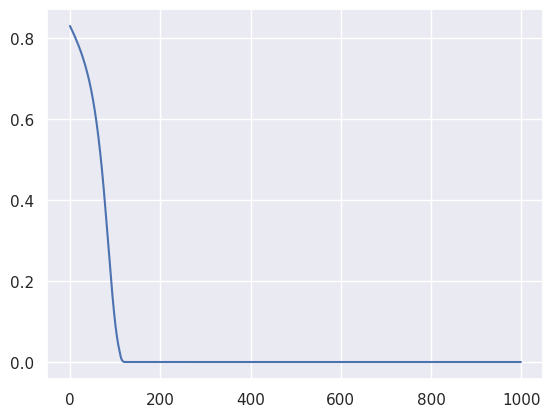

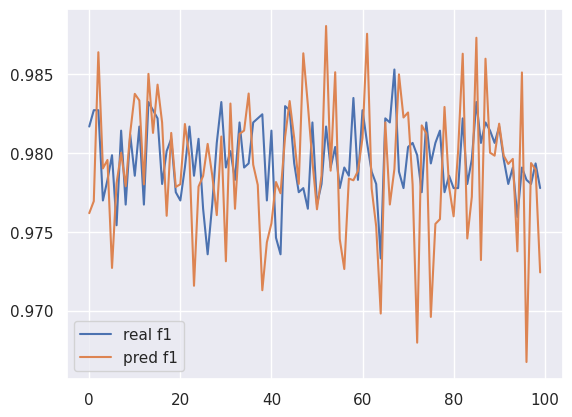

In [175]:
print('Learning PPM...')
ppm = train_regression_model(drifts,f1s)

# PPM 적용 Test

In [182]:
real_f1s = []
cbpe_f1s = []
ppm_f1s = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x_chunk,y_chunk in zip(tqdm(x_live_chunk),y_live_chunk):
    #print(x_chunk.iloc[:,0:4])
    y_pred = model.predict(scaler.transform(x_chunk.iloc[:,0:4].values))
    analysis_df = x_chunk
    analysis_df['y_pred_proba'] = model.predict_proba(scaler.transform(x_chunk.iloc[:,0:4].values))[:,1]
    analysis_df['y_pred'] =y_pred
    results = estimator.estimate(analysis_df)
    real_f1s.append(f1_score(y_chunk,y_pred))
    cbpe_f1s.append(results.filter(period='analysis').to_df()[[('f1','value')]].values[0,0])
    drift = __ks_drift(X3[0:train_size].values,x_chunk.iloc[:,0:4].values)
    ppm_f1s.append(ppm(torch.tensor(drift[:,0],dtype=torch.float32).to(device)).cpu().data.numpy())

100%|██████████| 125/125 [00:08<00:00, 14.01it/s]


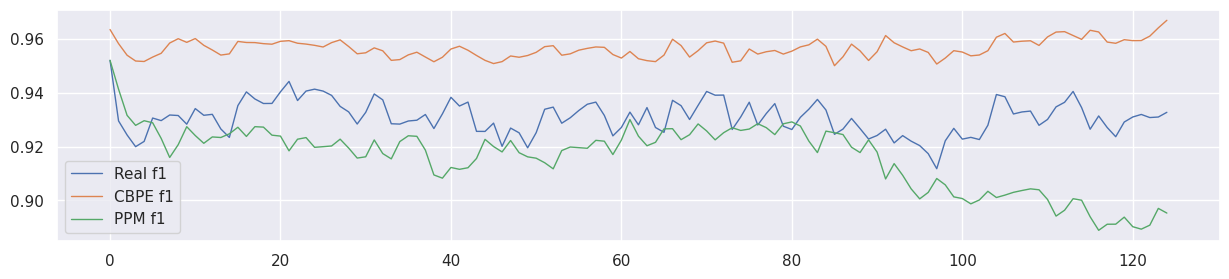

In [185]:
av = (real_f1s[0] - ppm_f1s[0])

plt.figure(figsize=(15,3))
plt.plot(real_f1s,linewidth=1,label='Real f1')
plt.plot(cbpe_f1s,linewidth=1,label='CBPE f1')
plt.plot(ppm_f1s+av,linewidth=1,label='PPM f1')
plt.legend()
plt.show()